# Notebook 03: Segmentacion de Nodulos Pulmonares

Este notebook presenta la arquitectura y flujo para segmentacion de nodulos pulmonares usando deep learning.

**Estado actual**: Esqueleto/Template - requiere entrenamiento con datos propios.

## Contenido:
1. **Modelo**: U-Net con encoder EfficientNet-B3
2. **Extraccion de Patches**: Recortes 2D centrados en nodulos
3. **Inferencia**: Flujo de segmentacion (requiere pesos entrenados)

---

## Arquitectura del Modelo

| Componente | Descripcion |
|------------|-------------|
| Arquitectura | U-Net + EfficientNet-B3 |
| Libreria | [segmentation-models-pytorch](https://github.com/qubvel/segmentation-models-pytorch) |
| Parametros | ~13M |

**Nota**: Para obtener resultados reales, se requiere entrenar el modelo con mascaras ground truth de LIDC-IDRI.

---

## 1. Configuracion del Entorno

In [1]:
# Detectar si estamos en Google Colab
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Ejecutando en Google Colab")
    print("="*50)
    
    # Instalar dependencias
    print("\nInstalando dependencias...")
    import subprocess
    paquetes = ['SimpleITK', 'scikit-image', 'requests', 'tqdm']
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + paquetes)
    
    # Clonar repositorio desde GitHub
    print("\nClonando repositorio desde GitHub...")
    repo_url = "https://github.com/Daspony/Imagenes-Biomedicas.git"
    repo_name = "Imagenes-Biomedicas"
    
    if not os.path.exists(f"/content/{repo_name}"):
        subprocess.run(["git", "clone", repo_url], cwd="/content", check=True)
        print(f"Repositorio clonado en /content/{repo_name}")
    else:
        print(f"Repositorio ya existe en /content/{repo_name}")
    
    # Anadir al path
    sys.path.insert(0, f"/content/{repo_name}")
    
    print("Configuracion de Colab completada\n")
    
else:
    print("Ejecutando localmente")
    print("="*50)
    
    # Anadir directorio padre al path para importar utils
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    
    print(f"Directorio de trabajo: {os.getcwd()}")
    print("Configuracion local completada\n")

Ejecutando localmente
Directorio de trabajo: c:\Users\Poney\Desktop\Imagenes Biomedicas\notebooks
Configuracion local completada



In [2]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from pathlib import Path
from tqdm import tqdm

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Segmentation Models PyTorch (para U-Net EfficientNet-B3)
try:
    import segmentation_models_pytorch as smp
    SMP_AVAILABLE = True
    print("segmentation-models-pytorch disponible")
except ImportError:
    SMP_AVAILABLE = False
    print("ADVERTENCIA: segmentation-models-pytorch no instalado")
    print("Instalar con: pip install segmentation-models-pytorch")

# Importar nuestros modulos
from utils import LUNA16DataLoader, LungPreprocessor, LungVisualizer, download_luna16

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDispositivo: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nLibrerias importadas correctamente")

segmentation-models-pytorch disponible

Dispositivo: cuda
GPU: NVIDIA GeForce RTX 2050

Librerias importadas correctamente


In [3]:
# Configuracion de rutas
if IN_COLAB:
    luna16_path = '/content/LUNA16'
    download_luna16(subsets=0, include_csv=True, download_dir=luna16_path)
    DATA_PATH = os.path.join(luna16_path, 'subset0')
    ANNOTATIONS_PATH = os.path.join(luna16_path, 'annotations.csv')
else:
    project_root = os.path.abspath('..')
    luna16_path = os.path.join(project_root, 'LUNA16')
    download_luna16(subsets=0, include_csv=True, download_dir=luna16_path)
    DATA_PATH = os.path.join(luna16_path, 'subset0')
    ANNOTATIONS_PATH = os.path.join(luna16_path, 'annotations.csv')

# Verificar rutas
print(f"Datos: {DATA_PATH}")
print(f"Anotaciones: {ANNOTATIONS_PATH}")
print(f"Anotaciones existe: {os.path.exists(ANNOTATIONS_PATH)}")

DESCARGA DE LUNA16 DESDE ZENODO
Directorio de destino: c:\Users\Poney\Desktop\Imagenes Biomedicas\LUNA16
Subsets a descargar: [0]
Incluyendo: annotations.csv y candidates.csv

[OK] subset0 ya existe (89 archivos .mhd), saltando
[OK] annotations ya existe, saltando
[OK] candidates ya existe, saltando

[SUCCESS] DESCARGA COMPLETADA
Datos disponibles en: c:\Users\Poney\Desktop\Imagenes Biomedicas\LUNA16
  - subset0: 89 archivos .mhd
Datos: c:\Users\Poney\Desktop\Imagenes Biomedicas\LUNA16\subset0
Anotaciones: c:\Users\Poney\Desktop\Imagenes Biomedicas\LUNA16\annotations.csv
Anotaciones existe: True


## 2. Modelo U-Net EfficientNet-B3

**Arquitectura**: U-Net con encoder EfficientNet-B3

Esta arquitectura combina:
- **Encoder**: EfficientNet-B3 (pre-entrenado en ImageNet, ~12M parametros)
- **Decoder**: U-Net con skip connections

EfficientNet-B3 ofrece un excelente balance entre precision y eficiencia computacional.

In [4]:
# Crear modelo U-Net con encoder EfficientNet-B3
if SMP_AVAILABLE:
    model_unet = smp.Unet(
        encoder_name="efficientnet-b3",
        encoder_weights=None,  # No cargar pesos de ImageNet, usaremos los de Kaggle
        in_channels=3,         # EfficientNet espera 3 canales (replicaremos el grayscale)
        classes=1              # Salida: mascara binaria
    ).to(device)
    
    print("U-Net EfficientNet-B3 creado")
    print(f"Parametros totales: {sum(p.numel() for p in model_unet.parameters()):,}")
else:
    print("No se pudo crear el modelo. Instalar segmentation-models-pytorch")
    model_unet = None

U-Net EfficientNet-B3 creado
Parametros totales: 13,159,033


### 2.1 Carga de Pesos (Opcional)

Si tienes pesos entrenados, puedes cargarlos aqui. Por ahora el modelo usa pesos aleatorios.

In [5]:
# Funcion para cargar pesos pre-entrenados (cuando esten disponibles)
def load_segmentation_weights(model, weights_path):
    """
    Carga pesos pre-entrenados en el modelo de segmentacion
    
    Args:
        model: Modelo U-Net EfficientNet-B3
        weights_path: Ruta al archivo .pth
    
    Returns:
        model: Modelo con pesos cargados
        success: True si se cargaron los pesos
    """
    if os.path.exists(weights_path):
        print(f"Cargando pesos desde: {weights_path}")
        try:
            state_dict = torch.load(weights_path, map_location=device)
            model.load_state_dict(state_dict)
            print("Pesos cargados exitosamente!")
            return model, True
        except Exception as e:
            print(f"Error al cargar pesos: {e}")
            return model, False
    else:
        print(f"Archivo no encontrado: {weights_path}")
        print("El modelo usara pesos aleatorios")
        return model, False


# Ruta a los pesos (cuando esten disponibles)
if IN_COLAB:
    WEIGHTS_PATH = '/content/weights/unet_nodulos.pth'
else:
    WEIGHTS_PATH = os.path.join(project_root, 'weights', 'unet_nodulos.pth')

# Por ahora no cargamos pesos externos (no funcionan con nuestros datos)
weights_loaded = False
print("Modelo inicializado con pesos aleatorios")
print("Para resultados reales, entrenar con mascaras de LIDC-IDRI")

Modelo inicializado con pesos aleatorios
Para resultados reales, entrenar con mascaras de LIDC-IDRI


---

## 3. Extraccion de Patches de Nodulos

Para entrenar/evaluar los modelos, necesitamos extraer patches (recortes) centrados en los nodulos anotados.

In [6]:
# Cargar datos
loader = LUNA16DataLoader(DATA_PATH, ANNOTATIONS_PATH)
preprocessor = LungPreprocessor()

# Cargar un escaneo con nodulos
annotations_df = pd.read_csv(ANNOTATIONS_PATH)
seriesuids_with_nodules = annotations_df['seriesuid'].unique()

# Buscar escaneo disponible con nodulos
mhd_files = list(Path(DATA_PATH).glob("*.mhd"))
selected_scan = None

for mhd_file in mhd_files:
    seriesuid = mhd_file.stem
    if seriesuid in seriesuids_with_nodules:
        selected_scan = mhd_file
        num_nodules = len(annotations_df[annotations_df['seriesuid'] == seriesuid])
        print(f"Escaneo seleccionado: {mhd_file.name}")
        print(f"Nodulos en este escaneo: {num_nodules}")
        break

if selected_scan is None:
    print("No se encontro un escaneo con nodulos anotados")

Anotaciones cargadas: 1186 nódulos
Escaneo seleccionado: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Nodulos en este escaneo: 1


In [7]:
# Cargar escaneo
ct_scan, origin, spacing = loader.load_itk_image(str(selected_scan))

# Obtener anotaciones
seriesuid = selected_scan.stem
scan_annotations = annotations_df[annotations_df['seriesuid'] == seriesuid]

print(f"\nVolumen CT: {ct_scan.shape}")
print(f"Spacing: {spacing}")
print(f"\nAnotaciones:")
print(scan_annotations[['coordX', 'coordY', 'coordZ', 'diameter_mm']])


Volumen CT: (119, 512, 512)
Spacing: [2.5        0.74218798 0.74218798]

Anotaciones:
        coordX     coordY      coordZ  diameter_mm
23 -100.567944  67.260517 -231.816619     6.440879


In [8]:
def extract_nodule_patch(ct_volume, center_world, origin, spacing, patch_size=64):
    """
    Extrae un patch 3D centrado en un nodulo
    
    Args:
        ct_volume: Volumen CT completo (z, y, x)
        center_world: Coordenadas del centro en mm (x, y, z)
        origin: Origen del volumen en mm
        spacing: Espaciado en mm
        patch_size: Tamano del patch en pixeles
    
    Returns:
        patch_3d: Patch 3D (depth, height, width)
        center_voxel: Coordenadas del centro en voxeles
    """
    # Convertir coordenadas mundo a voxel
    center_voxel = np.array([
        (center_world[2] - origin[0]) / spacing[0],  # z
        (center_world[1] - origin[1]) / spacing[1],  # y
        (center_world[0] - origin[2]) / spacing[2],  # x
    ]).astype(int)
    
    # Calcular limites del patch
    half_size = patch_size // 2
    z_min = max(0, center_voxel[0] - half_size // 4)  # Menos slices en z
    z_max = min(ct_volume.shape[0], center_voxel[0] + half_size // 4)
    y_min = max(0, center_voxel[1] - half_size)
    y_max = min(ct_volume.shape[1], center_voxel[1] + half_size)
    x_min = max(0, center_voxel[2] - half_size)
    x_max = min(ct_volume.shape[2], center_voxel[2] + half_size)
    
    # Extraer patch
    patch_3d = ct_volume[z_min:z_max, y_min:y_max, x_min:x_max]
    
    return patch_3d, center_voxel


def extract_nodule_patch_2d(ct_volume, center_world, origin, spacing, patch_size=64):
    """
    Extrae un patch 2D del slice central del nodulo
    
    Args:
        ct_volume: Volumen CT completo (z, y, x)
        center_world: Coordenadas del centro en mm (x, y, z)
        origin: Origen del volumen en mm
        spacing: Espaciado en mm
        patch_size: Tamano del patch en pixeles
    
    Returns:
        patch_2d: Patch 2D (height, width)
        center_voxel: Coordenadas del centro en voxeles
    """
    # Convertir coordenadas mundo a voxel
    center_voxel = np.array([
        (center_world[2] - origin[0]) / spacing[0],  # z
        (center_world[1] - origin[1]) / spacing[1],  # y
        (center_world[0] - origin[2]) / spacing[2],  # x
    ]).astype(int)
    
    # Obtener slice central
    slice_idx = center_voxel[0]
    ct_slice = ct_volume[slice_idx]
    
    # Calcular limites del patch
    half_size = patch_size // 2
    y_min = max(0, center_voxel[1] - half_size)
    y_max = min(ct_slice.shape[0], center_voxel[1] + half_size)
    x_min = max(0, center_voxel[2] - half_size)
    x_max = min(ct_slice.shape[1], center_voxel[2] + half_size)
    
    # Extraer patch
    patch_2d = ct_slice[y_min:y_max, x_min:x_max]
    
    # Padding si el patch es mas pequeno que patch_size
    if patch_2d.shape[0] < patch_size or patch_2d.shape[1] < patch_size:
        padded = np.zeros((patch_size, patch_size), dtype=patch_2d.dtype)
        padded[:patch_2d.shape[0], :patch_2d.shape[1]] = patch_2d
        patch_2d = padded
    
    return patch_2d, center_voxel


print("Funciones de extraccion de patches definidas")

Funciones de extraccion de patches definidas


In [9]:
# Extraer patches de todos los nodulos del escaneo
patches_2d = []
nodule_info = []

for idx, row in scan_annotations.iterrows():
    center_world = np.array([row['coordX'], row['coordY'], row['coordZ']])
    diameter = row['diameter_mm']
    
    # Extraer patch 2D
    patch, center_voxel = extract_nodule_patch_2d(
        ct_scan, center_world, origin, spacing, patch_size=64
    )
    
    patches_2d.append(patch)
    nodule_info.append({
        'center_voxel': center_voxel,
        'center_world': center_world,
        'diameter_mm': diameter
    })

print(f"Patches extraidos: {len(patches_2d)}")

Patches extraidos: 1


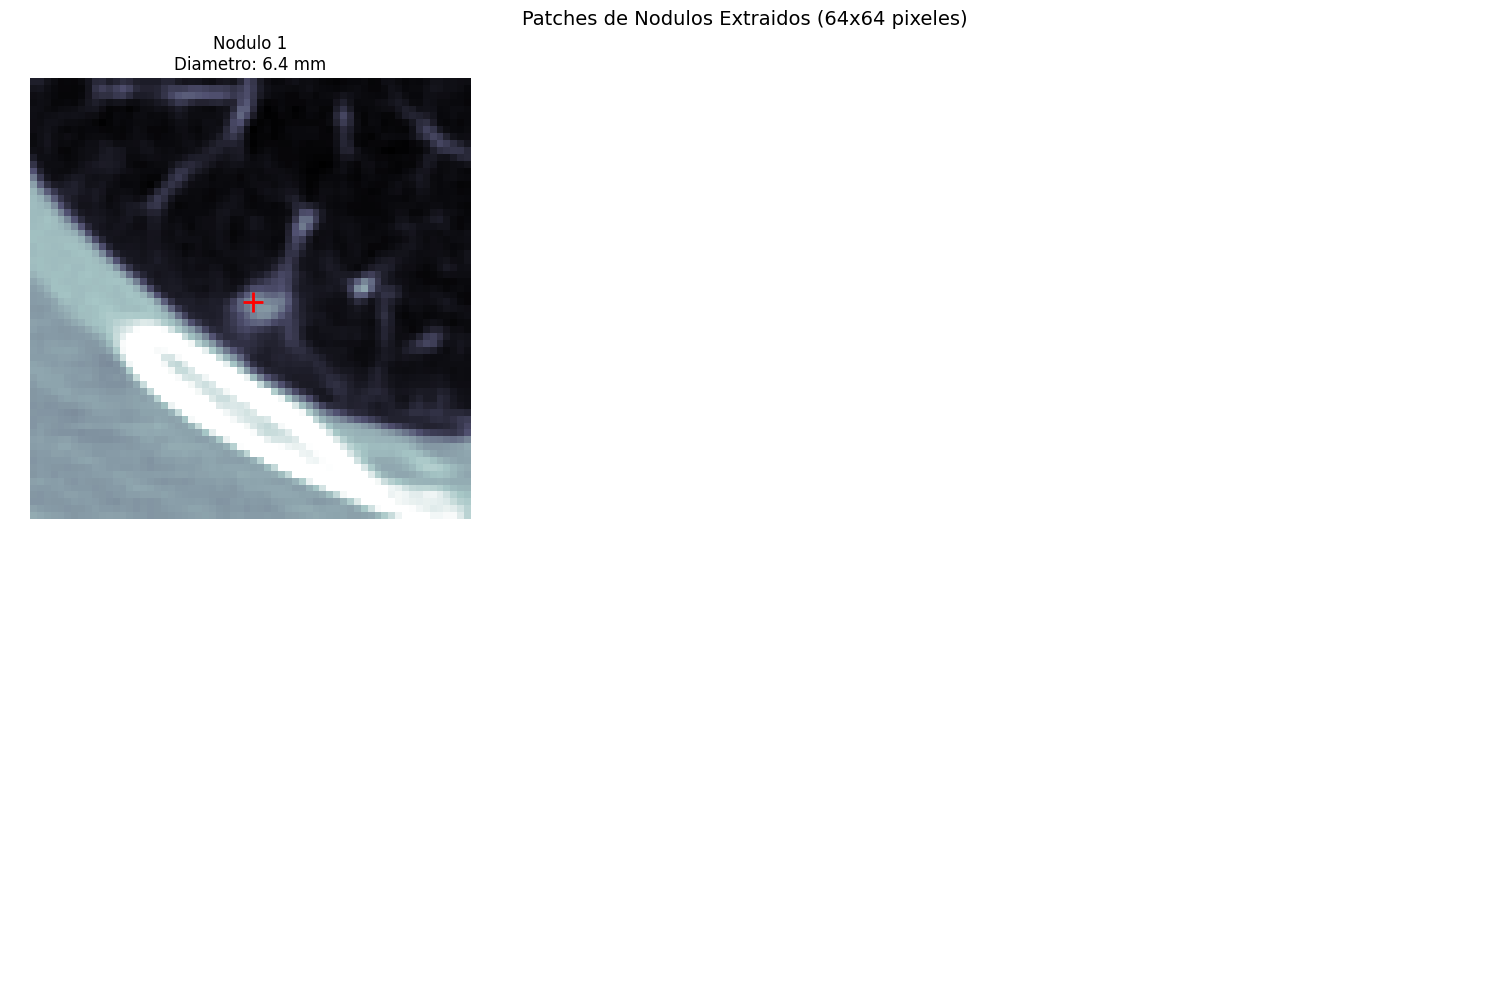

In [10]:
# Visualizar patches extraidos
num_patches = min(len(patches_2d), 6)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_patches):
    patch = patches_2d[i]
    info = nodule_info[i]
    
    # Normalizar para visualizacion
    patch_norm = loader.normalize_hu(patch, min_hu=-1000, max_hu=400)
    
    axes[i].imshow(patch_norm, cmap='bone')
    axes[i].set_title(f"Nodulo {i+1}\nDiametro: {info['diameter_mm']:.1f} mm")
    axes[i].axis('off')
    
    # Marcar centro
    center = patch.shape[0] // 2
    axes[i].plot(center, center, 'r+', markersize=15, markeredgewidth=2)

# Ocultar ejes vacios
for i in range(num_patches, len(axes)):
    axes[i].axis('off')

plt.suptitle('Patches de Nodulos Extraidos (64x64 pixeles)', fontsize=14)
plt.tight_layout()
plt.show()

---

## 4. Dataset y DataLoader para PyTorch

In [11]:
class NoduleDataset(Dataset):
    """
    Dataset de patches de nodulos para PyTorch
    
    Args:
        data_path: Ruta a los datos LUNA16
        annotations_path: Ruta al CSV de anotaciones
        patch_size: Tamano del patch
        transform: Transformaciones opcionales
    """
    def __init__(self, data_path, annotations_path, patch_size=64, transform=None):
        self.data_path = data_path
        self.patch_size = patch_size
        self.transform = transform
        
        # Cargar anotaciones
        self.annotations_df = pd.read_csv(annotations_path)
        self.loader = LUNA16DataLoader(data_path, annotations_path)
        
        # Filtrar solo escaneos disponibles
        available_scans = [f.stem for f in Path(data_path).glob("*.mhd")]
        self.annotations_df = self.annotations_df[
            self.annotations_df['seriesuid'].isin(available_scans)
        ]
        
        # Cache para escaneos cargados
        self._scan_cache = {}
    
    def __len__(self):
        return len(self.annotations_df)
    
    def _load_scan(self, seriesuid):
        """Carga un escaneo con cache"""
        if seriesuid not in self._scan_cache:
            scan_path = os.path.join(self.data_path, f"{seriesuid}.mhd")
            ct_scan, origin, spacing = self.loader.load_itk_image(scan_path)
            self._scan_cache[seriesuid] = (ct_scan, origin, spacing)
        return self._scan_cache[seriesuid]
    
    def __getitem__(self, idx):
        row = self.annotations_df.iloc[idx]
        seriesuid = row['seriesuid']
        
        # Cargar escaneo
        ct_scan, origin, spacing = self._load_scan(seriesuid)
        
        # Extraer patch
        center_world = np.array([row['coordX'], row['coordY'], row['coordZ']])
        patch, _ = extract_nodule_patch_2d(ct_scan, center_world, origin, spacing, self.patch_size)
        
        # Normalizar
        patch = self.loader.normalize_hu(patch, min_hu=-1000, max_hu=400)
        
        # Convertir a tensor
        patch = torch.FloatTensor(patch).unsqueeze(0)  # Agregar canal
        
        # Aplicar transformaciones
        if self.transform:
            patch = self.transform(patch)
        
        # Por ahora, etiqueta dummy (0: benigno, 1: maligno)
        # En un caso real, usarias las etiquetas de LIDC-IDRI
        label = 0  # Placeholder
        
        return patch, label, row['diameter_mm']


# Crear dataset
dataset = NoduleDataset(DATA_PATH, ANNOTATIONS_PATH, patch_size=64)
print(f"Dataset creado con {len(dataset)} nodulos")

Anotaciones cargadas: 1186 nódulos
Dataset creado con 112 nodulos


In [12]:
# Crear DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# Obtener un batch de ejemplo
batch_patches, batch_labels, batch_diameters = next(iter(dataloader))

print(f"Batch shape: {batch_patches.shape}")
print(f"Labels: {batch_labels}")
print(f"Diametros: {batch_diameters}")

Batch shape: torch.Size([4, 1, 64, 64])
Labels: tensor([0, 0, 0, 0])
Diametros: tensor([ 4.3432, 17.3362, 10.8312, 11.1755], dtype=torch.float64)


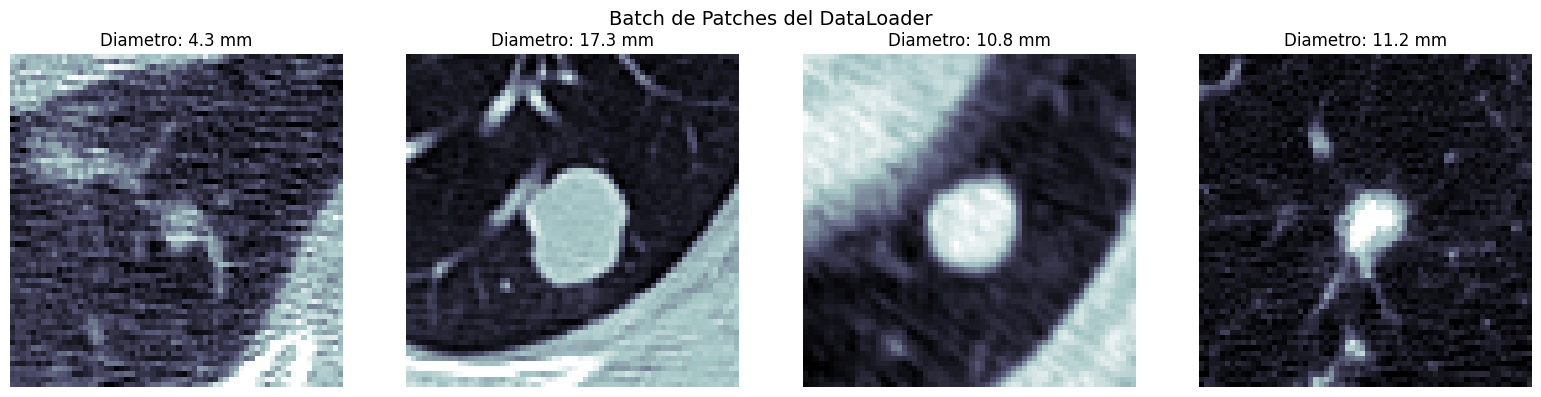

In [13]:
# Visualizar batch
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    patch = batch_patches[i, 0].numpy()  # Remover dimension de canal
    axes[i].imshow(patch, cmap='bone')
    axes[i].set_title(f"Diametro: {batch_diameters[i]:.1f} mm")
    axes[i].axis('off')

plt.suptitle('Batch de Patches del DataLoader', fontsize=14)
plt.tight_layout()
plt.show()

---

## 5. Segmentacion de Nodulos con U-Net

**IMPORTANTE**: Esta seccion muestra el flujo de inferencia. Los resultados actuales no son correctos porque se requiere entrenar el modelo con mascaras ground truth de LIDC-IDRI.

El modelo pre-entrenado de Kaggle no funciona correctamente con nuestros datos debido a diferencias en:
- Preprocesamiento de imagenes
- Tamano de patches
- Normalizacion de valores HU

In [14]:
def segment_nodule(model, patch, threshold=0.5):
    """
    Segmenta un nodulo usando U-Net EfficientNet-B3
    
    Args:
        model: Modelo U-Net
        patch: Patch 2D normalizado (H, W) o (C, H, W)
        threshold: Umbral para binarizacion
    
    Returns:
        mask: Mascara binaria del nodulo
        prob_map: Mapa de probabilidades
    """
    if model is None:
        print("Modelo no disponible")
        return None, None
    
    model.eval()
    
    # Preparar input
    if isinstance(patch, np.ndarray):
        patch = torch.FloatTensor(patch)
    
    # Asegurar dimensiones correctas
    if patch.dim() == 2:
        # Grayscale (H, W) -> (1, 3, H, W) replicando canal
        patch = patch.unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)
    elif patch.dim() == 3:
        if patch.shape[0] == 1:
            # (1, H, W) -> (1, 3, H, W)
            patch = patch.repeat(3, 1, 1).unsqueeze(0)
        elif patch.shape[0] == 3:
            # (3, H, W) -> (1, 3, H, W)
            patch = patch.unsqueeze(0)
    
    patch = patch.to(device)
    
    # Inferencia
    with torch.no_grad():
        prob_map = model(patch)
        prob_map = torch.sigmoid(prob_map)  # Asegurar probabilidades
    
    # Convertir a numpy
    prob_map = prob_map.squeeze().cpu().numpy()
    mask = (prob_map > threshold).astype(np.uint8)
    
    return mask, prob_map


# Probar segmentacion
if model_unet is not None and len(patches_2d) > 0:
    test_patch = patches_2d[0]
    test_patch_norm = loader.normalize_hu(test_patch, min_hu=-1000, max_hu=400)
    
    mask, prob_map = segment_nodule(model_unet, test_patch_norm)
    
    if mask is not None:
        print(f"Patch shape: {test_patch.shape}")
        print(f"Mask shape: {mask.shape}")
        print(f"Prob map range: [{prob_map.min():.3f}, {prob_map.max():.3f}]")
        
        if weights_loaded:
            print("\nUsando modelo con pesos pre-entrenados de Kaggle")
        else:
            print("\nUsando modelo sin entrenar (resultados aleatorios)")

Patch shape: (64, 64)
Mask shape: (64, 64)
Prob map range: [0.424, 0.507]

Usando modelo sin entrenar (resultados aleatorios)


NOTA: Los resultados son aleatorios porque el modelo no esta entrenado


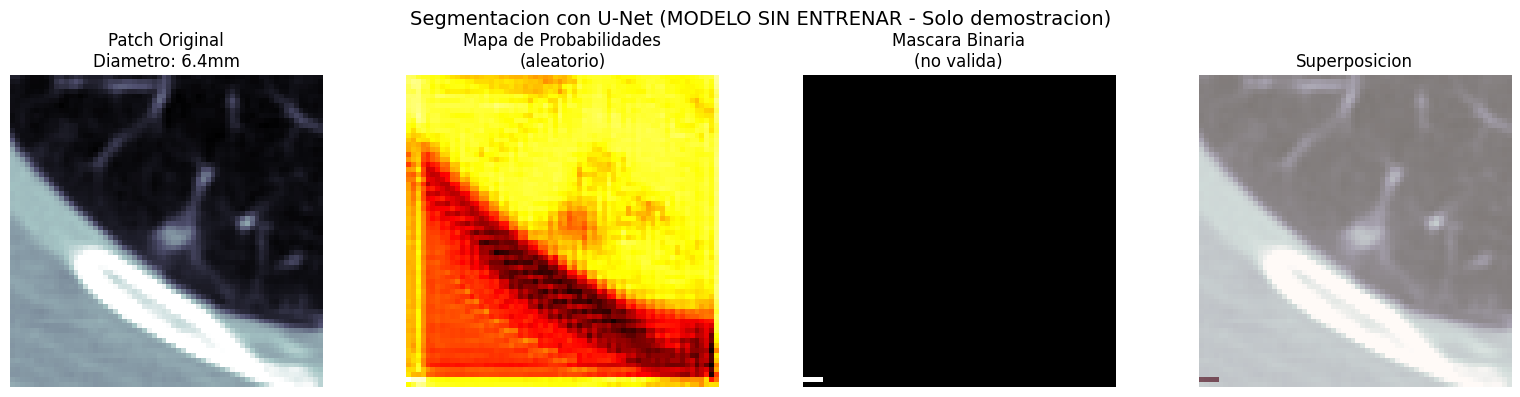


Para obtener resultados reales:
  1. Descargar LIDC-IDRI con mascaras ground truth
  2. Entrenar el modelo con esos datos


In [15]:
# Ejemplo de segmentacion (resultados no validos sin entrenamiento)
print("NOTA: Los resultados son aleatorios porque el modelo no esta entrenado")
print("="*60)

# Obtener un patch de ejemplo
patch_tensor, label, diameter = dataset[0]
patch_np = patch_tensor.squeeze().numpy()

# Segmentar
mask, prob_map = segment_nodule(model_unet, patch_np)

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(patch_np, cmap='bone')
axes[0].set_title(f'Patch Original\nDiametro: {diameter:.1f}mm')
axes[0].axis('off')

axes[1].imshow(prob_map, cmap='hot')
axes[1].set_title('Mapa de Probabilidades\n(aleatorio)')
axes[1].axis('off')

axes[2].imshow(mask, cmap='gray')
axes[2].set_title('Mascara Binaria\n(no valida)')
axes[2].axis('off')

axes[3].imshow(patch_np, cmap='bone')
axes[3].imshow(mask, cmap='Reds', alpha=0.5)
axes[3].set_title('Superposicion')
axes[3].axis('off')

plt.suptitle('Segmentacion con U-Net (MODELO SIN ENTRENAR - Solo demostracion)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nPara obtener resultados reales:")
print("  1. Descargar LIDC-IDRI con mascaras ground truth")
print("  2. Entrenar el modelo con esos datos")

---

## 6. Resumen y Trabajo Futuro

### Estado actual:
- Arquitectura U-Net + EfficientNet-B3 implementada
- Flujo de extraccion de patches
- **Pendiente**: Entrenar modelo con datos propios

### Para obtener segmentacion funcional:

1. **Descargar LIDC-IDRI completo** (~125 GB) que incluye:
   - Contornos de nodulos dibujados por radiologos
   - Mascaras ground truth para entrenamiento

2. **Usar pylidc** para extraer mascaras:
   ```python
   import pylidc as pl
   nodule = scan.cluster_annotations()[0]
   mask = nodule[0].boolean_mask()  # Mascara 3D del nodulo
   ```

3. **Entrenar el modelo** con nuestros patches y mascaras

### Referencias:
- [LUNA16 Challenge](https://luna16.grand-challenge.org/)
- [LIDC-IDRI Dataset](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI)
- [pylidc Documentation](https://pylidc.github.io/)
- [Segmentation Models PyTorch](https://github.com/qubvel/segmentation-models-pytorch)

In [ ]:
print("="*60)
print("RESUMEN DEL NOTEBOOK 03: SEGMENTACION DE NODULOS")
print("="*60)
print("\nEstado: ESQUELETO/TEMPLATE")
print("\nModelo: U-Net + EfficientNet-B3")
if model_unet is not None:
    print(f"Parametros: {sum(p.numel() for p in model_unet.parameters()):,}")
print(f"\nDataset:")
print(f"  - Nodulos disponibles: {len(dataset)}")
print(f"  - Patch size: 64x64 pixeles")
print(f"\nPendiente:")
print("  1. Descargar LIDC-IDRI completo")
print("  2. Extraer mascaras con pylidc")
print("  3. Entrenar modelo con datos propios")